## Solution of the home assignment for Emplifi


### Javad M.Rad
### javad_mohamadi_rad@yahoo.com
### +420 721024504

# 1. Environment Setup and loading libraries

In [1]:
import json
import os
import numpy as np
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering

from wordcloud import WordCloud
import matplotlib.pyplot as plt


# 2. Data Loading and Preprocessing

In [2]:
# Load data
current_folder = os.getcwd()  # Get the current working directory
assignment_folder = os.path.join(current_folder, "assignment")  # Navigate to the 'assignment' subfolder
input_json_path = os.path.join(assignment_folder, "posts_with_topics.json")  # Full path to the JSON file
with open(input_json_path, 'r', encoding='utf-8') as f:
    posts = json.load(f)

# Collect all unique topics
all_topics = set()
for post in posts:
    for t in post["topics"]:
        all_topics.add(t)

all_topics = list(all_topics)  # convert to list for stable indexing
topic_index = {topic: i for i, topic in enumerate(all_topics)}
num_topics = len(all_topics)

print('Number of unique topics: ', num_topics)

Number of unique topics:  110


# 3. Creating the Co-occurrence Matrix
A common way to measure how closely topics are related is to compute Co-occurrence Matrix that is, how often they appear together.

In [3]:
# Initialize a co-occurrence matrix (num_topics x num_topics)
co_matrix = np.zeros((num_topics, num_topics), dtype=int)

# Populate the matrix
for post in posts:
    ts = post["topics"]
    # Generate all pairs of topics from the list
    for i in range(len(ts)):
        for j in range(i+1, len(ts)):
            idx_i = topic_index[ts[i]]
            idx_j = topic_index[ts[j]]
            co_matrix[idx_i, idx_j] += 1
            co_matrix[idx_j, idx_i] += 1

# Also track frequency of each topic across all posts
topic_frequency = np.zeros(num_topics, dtype=int)
for post in posts:
    for t in post["topics"]:
        topic_frequency[topic_index[t]] += 1

# Quick checks
print("Co-occurrence matrix shape:", co_matrix.shape)
print("Example row (first topic):", co_matrix[0, :])

Co-occurrence matrix shape: (110, 110)
Example row (first topic): [ 0  1  1  3 12 22  2  2  0  0  3  3  0  0  7  0 14  0  1  0  1 19 12  0
  8 11 13  3  0 17  5 16  3  1  2 30 17 17  0  2  0  0  0 11  7  4  0  3
  0  0  0 18  0  1  3  5  0  7  3  2  2  9  1  0  0  0  5  9  1  3  0  7
  0  1  2  0 34 12 12 97 21  9  0 17 27  0  8  1  0 10  0  0 35  0  0  1
 16  4 44  1  6  0  6  6 13  1  0  2  9  0]


# 4. Hierarchical Clustering
We'll define a recursive function that:
1) Clusters the given list of topic indices (topic_indices).
2) Splits them into sub-clusters if they exceed certain size / depth.
3) Returns a hierarchical tree.

In [4]:
def hierarchical_clustering(topic_indices, co_matrix, depth=0, max_depth=3, min_cluster_size=5, n_subclusters=3):
    """
    Recursively cluster a subset of topics (topic_indices) using agglomerative clustering on co-occurrence data.
    
    Args:
        topic_indices (list[int]): Indices of topics to be clustered at this node.
        co_matrix (np.array): Full co-occurrence matrix of shape (num_topics, num_topics).
        depth (int): Current recursion depth.
        max_depth (int): Maximum levels of hierarchy.
        min_cluster_size (int): If a cluster has fewer than this, do not subdivide further.
        n_subclusters (int): Number of subclusters to create at each level.

    Returns:
        dict: {
           "topics": list of topic indices at this node,
           "subclusters": list of child cluster dicts
        }
    """
    # Base condition checks
    if depth >= max_depth or len(topic_indices) < min_cluster_size:
        return {
            "topics": topic_indices,
            "subclusters": []
        }
    
    # Subset the co-occurrence matrix for these topics
    sub_matrix = co_matrix[np.ix_(topic_indices, topic_indices)]
    
    # Convert co-occurrence to a distance matrix
    # e.g. we can do max(sub_matrix) - sub_matrix so that high co-occurrence => small distance
    co_max = sub_matrix.max()
    dist_matrix = co_max - sub_matrix
    
    # Clustering model (Agglomerative)
    # "metric='precomputed'" means we supply a distance matrix directly
    # "linkage='average'" is one of the standard linkage types
    cluster_model = AgglomerativeClustering(
        metric='precomputed',
        linkage='average',
        n_clusters=min(n_subclusters, len(topic_indices))  # not more clusters than topics!
    )
    labels = cluster_model.fit_predict(dist_matrix)
    
    # Group topics by assigned cluster
    clusters_dict = defaultdict(list)
    for i, label in enumerate(labels):
        clusters_dict[label].append(topic_indices[i])
    
    # Recursively cluster each child
    subclusters = []
    for _, child_topic_indices in clusters_dict.items():
        child_cluster = hierarchical_clustering(
            topic_indices=child_topic_indices,
            co_matrix=co_matrix,
            depth=depth+1,
            max_depth=max_depth,
            min_cluster_size=min_cluster_size,
            n_subclusters=n_subclusters
        )
        subclusters.append(child_cluster)
    
    return {
        "topics": topic_indices,
        "subclusters": subclusters
    }

# Let's cluster everything at the top-level
root_cluster = hierarchical_clustering(
    topic_indices=list(range(num_topics)),
    co_matrix=co_matrix,
    depth=0,
    max_depth=3,          # Up to three levels deep
    min_cluster_size=5,   # If a cluster has fewer than 5 topics, don't split further
    n_subclusters=4       # Attempt up to 4 subclusters at each recursion level
)

# 5. Building a Tree Structure and Saving the Hierarchy as JSON

In [5]:
# Building a Tree Structure
def build_output_tree(cluster_node, all_topics, topic_frequency):
    """
    Transform the hierarchical clustering node into a JSON-ready structure with:
    - 'topics': a list of { "topic": str, "frequency": int }
    - 'children': a list of subclusters
    
    Args:
        cluster_node (dict): A node from hierarchical_clustering
        all_topics (list[str]): Master list of topic strings
        topic_frequency (np.array): Frequencies of each topic index

    Returns:
        dict: { "topics": [...], "children": [...] }
    """
    topic_data = []
    for idx in cluster_node["topics"]:
        topic_data.append({
            "topic": all_topics[idx],
            "frequency": int(topic_frequency[idx])
        })

    children = []
    for sub_node in cluster_node["subclusters"]:
        children.append(build_output_tree(sub_node, all_topics, topic_frequency))

    return {
        "topics": topic_data,
        "children": children
    }

hierarchy_json = build_output_tree(root_cluster, all_topics, topic_frequency)

# Save as JSON
output_json_path = 'small_data_topics_hierarchy.json'
print(f"Saving hierarchy to {output_json_path}")
with open(output_json_path, 'w', encoding='utf-8') as f:
    json.dump(hierarchy_json, f, indent=2, ensure_ascii=False)

print("Hierarchy successfully saved!")

Saving hierarchy to small_data_topics_hierarchy.json
Hierarchy successfully saved!


# 6. Visualization with Word Cloud

Displaying Word Cloud for All Topics


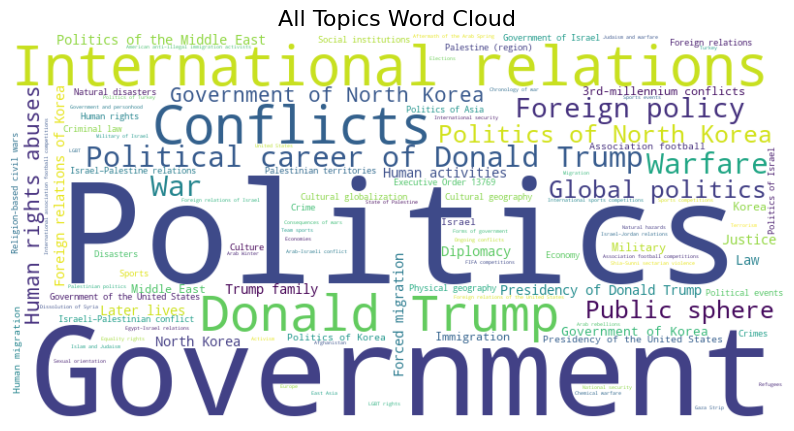

Displaying Word Clouds for Clusters


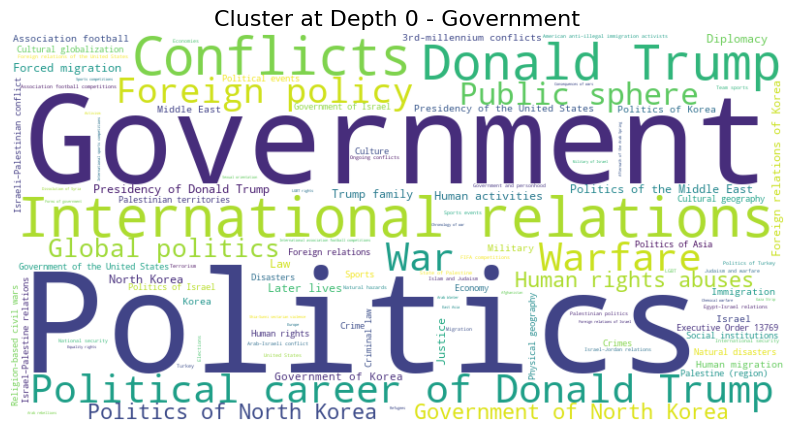

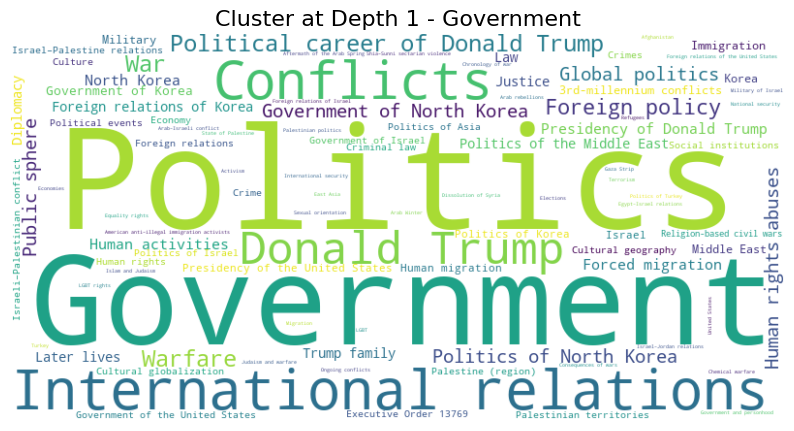

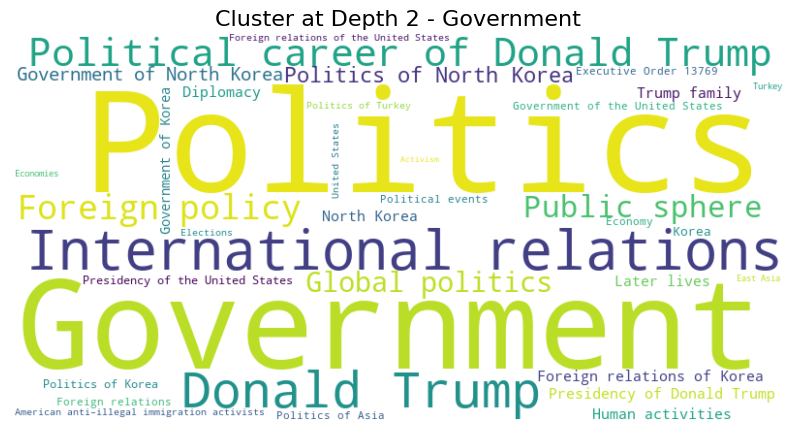

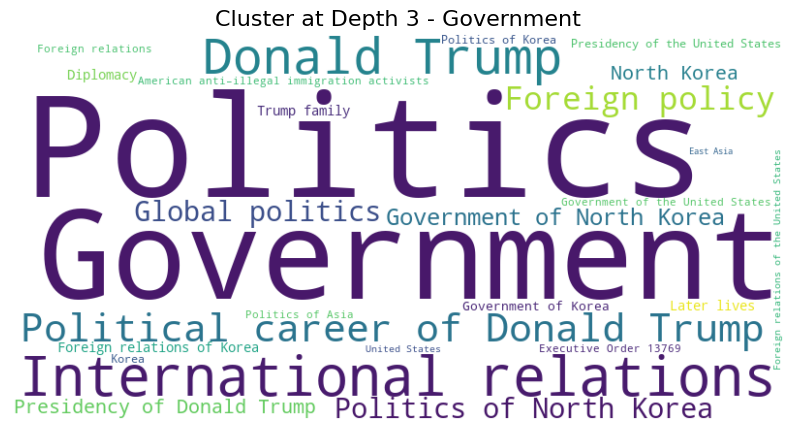

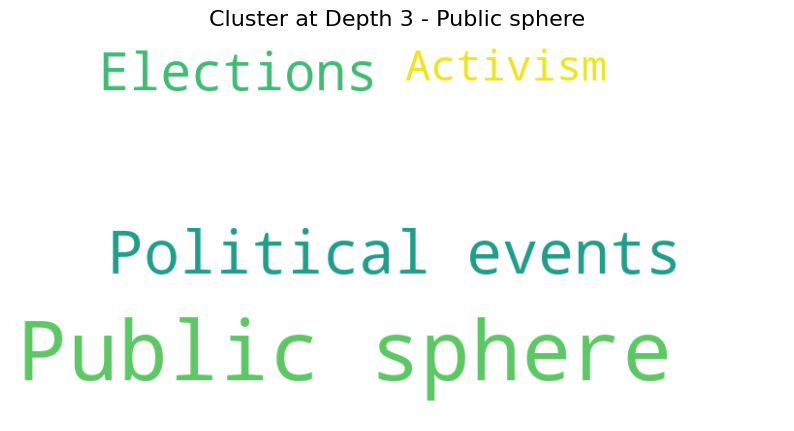

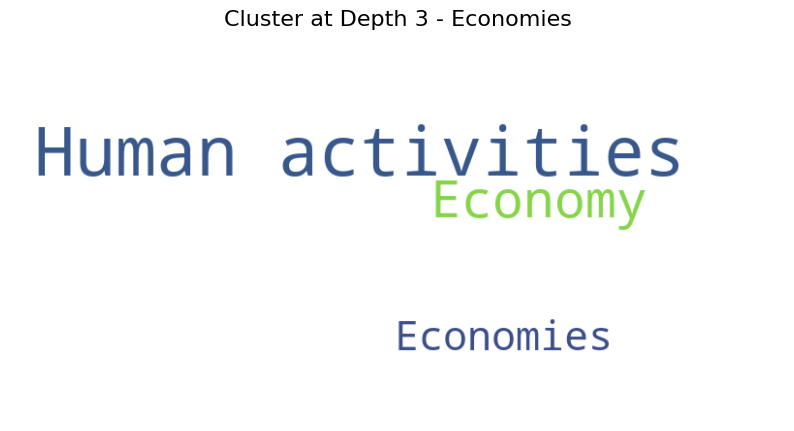

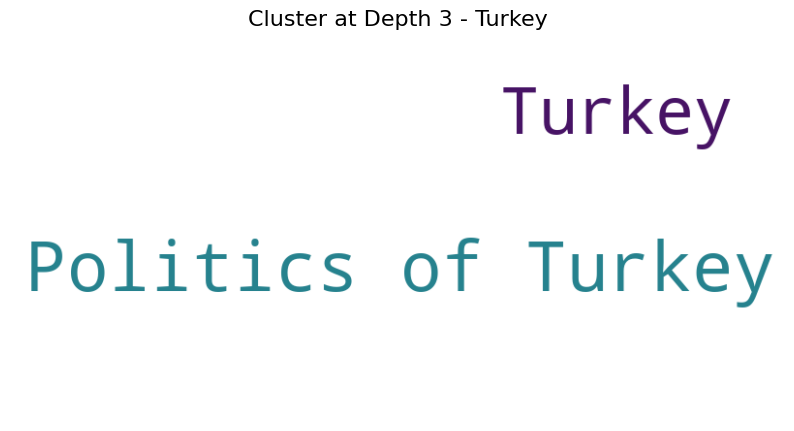

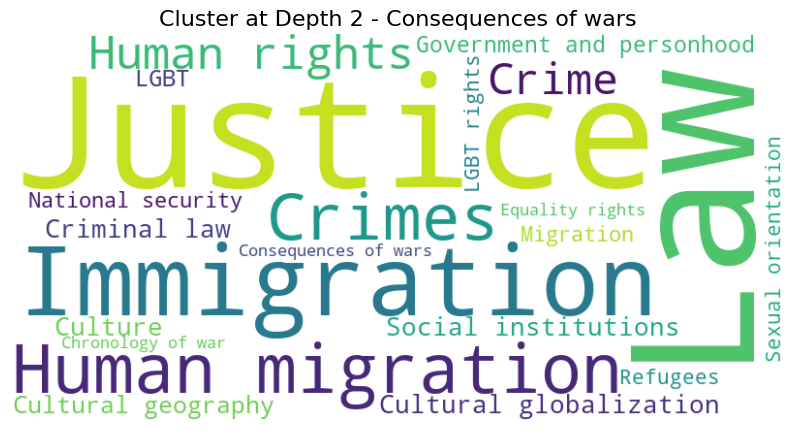

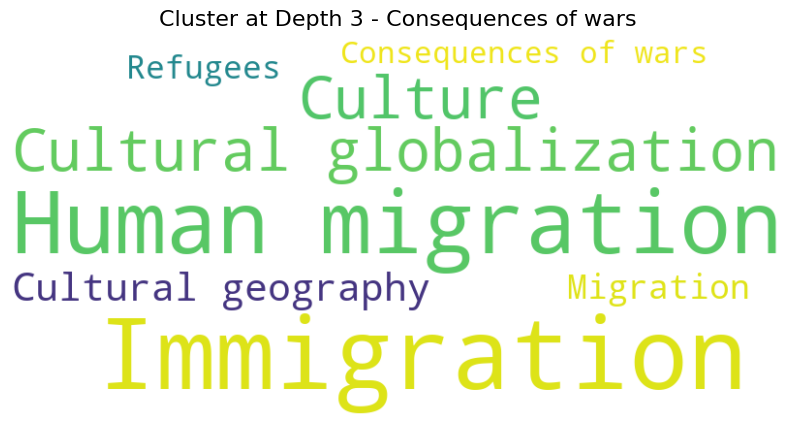

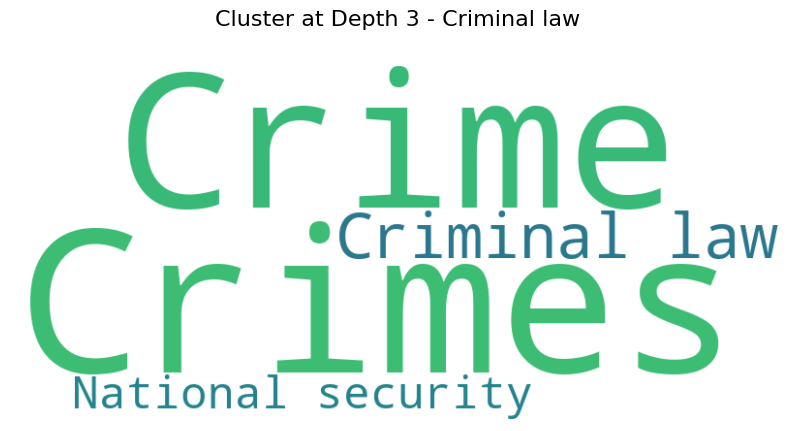

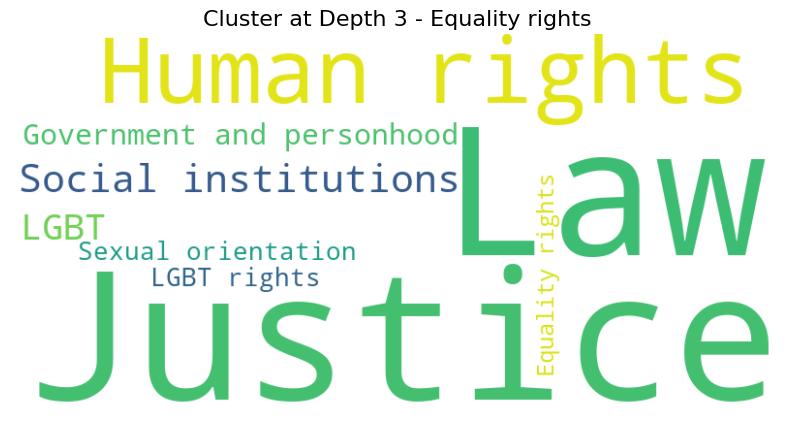

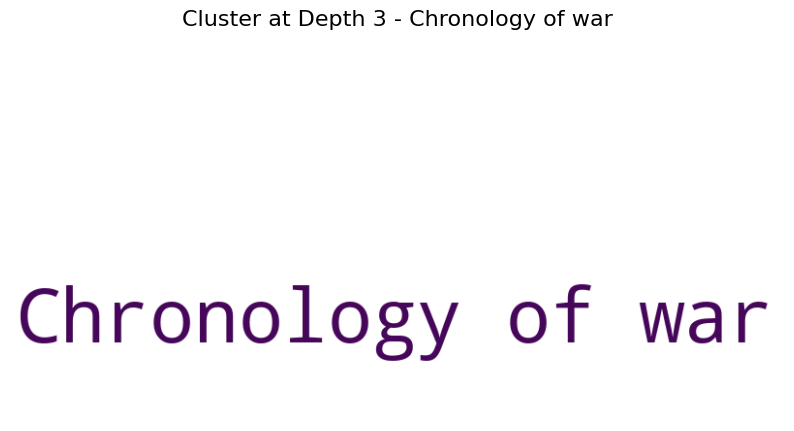

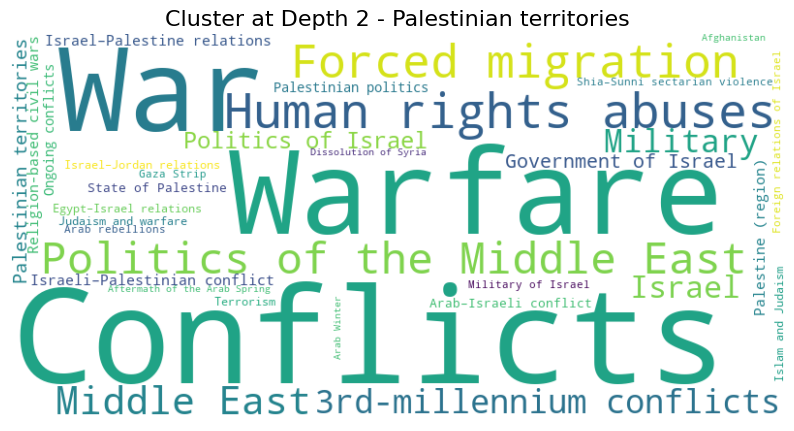

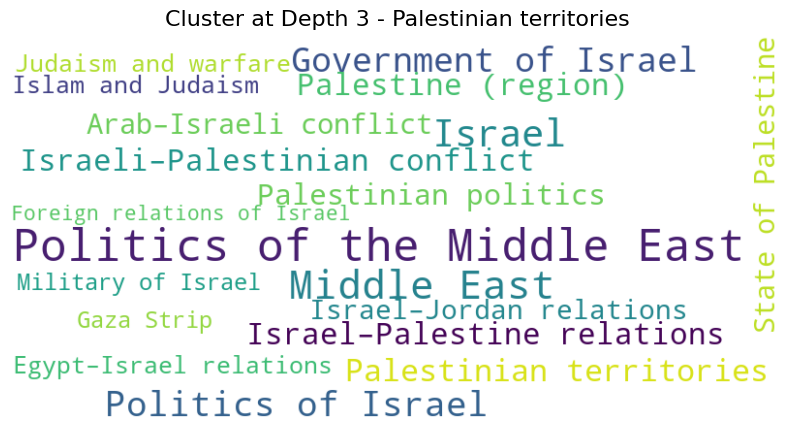

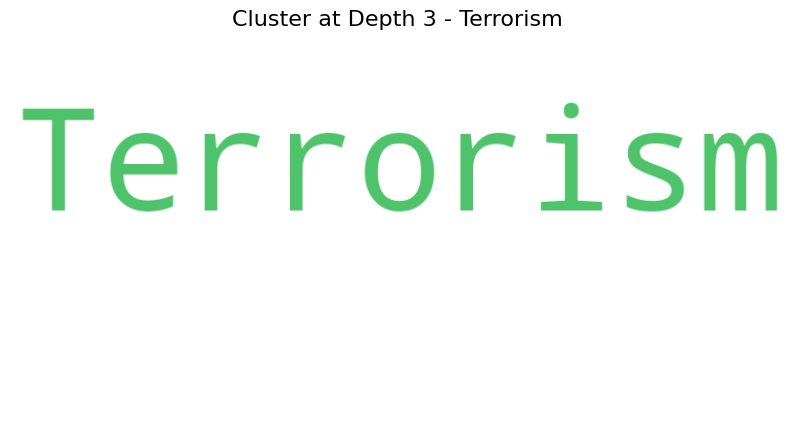

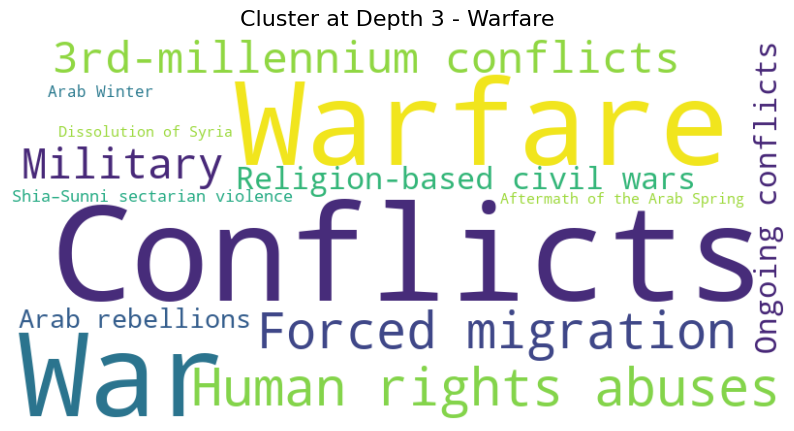

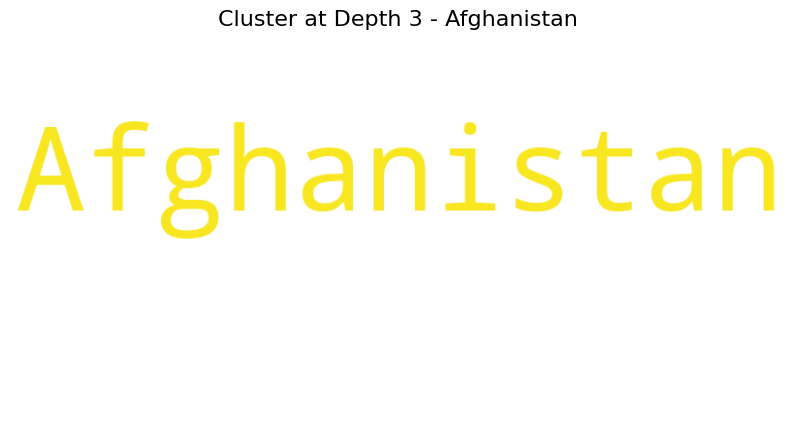

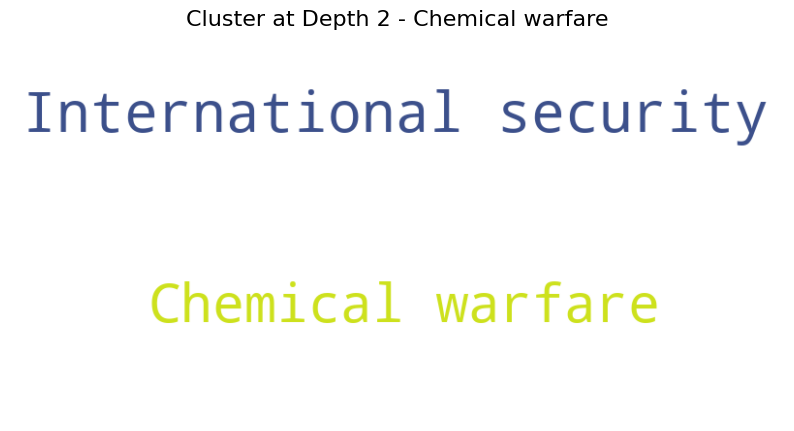

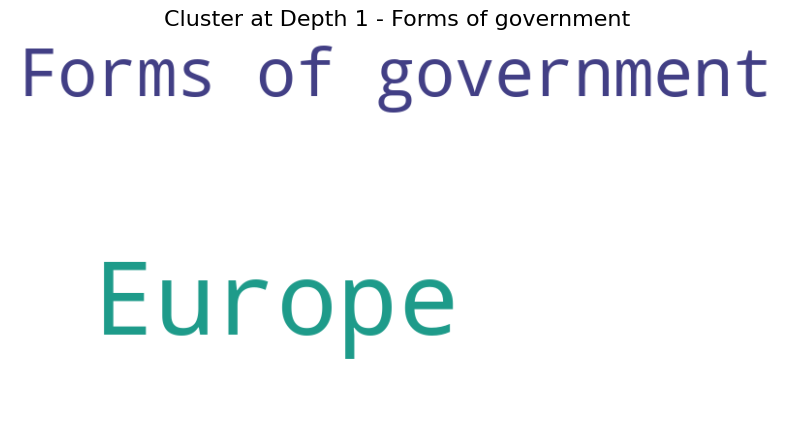

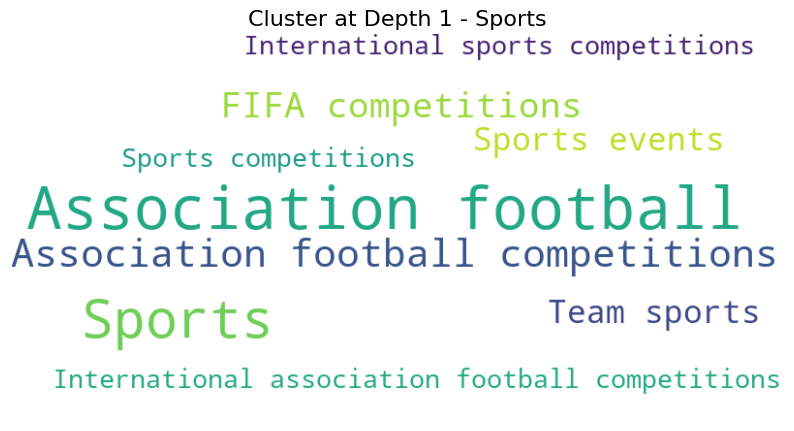

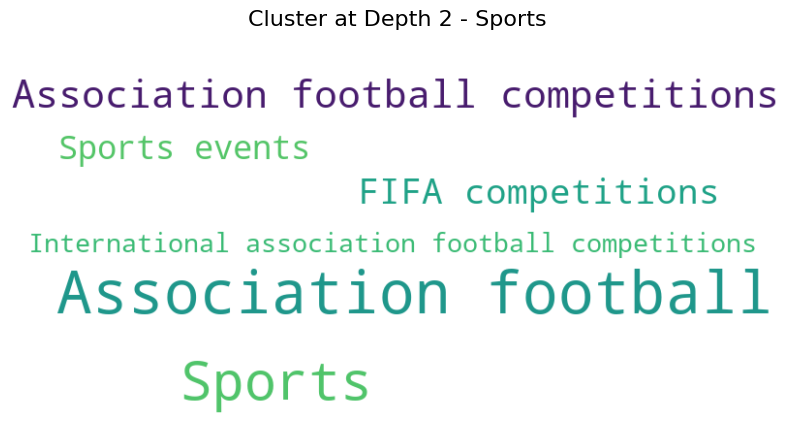

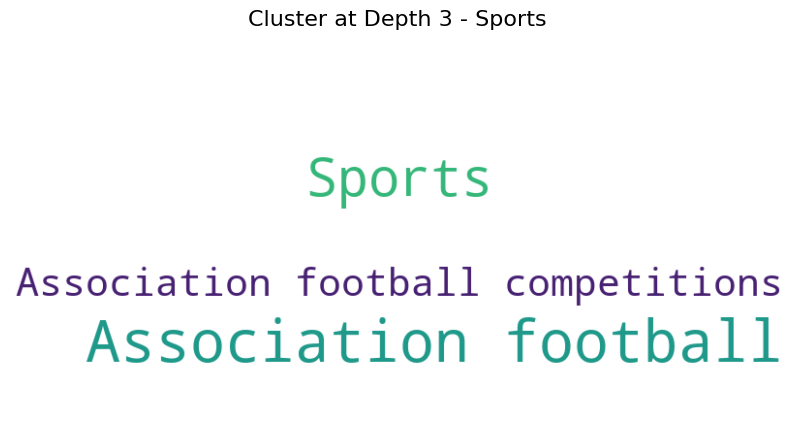

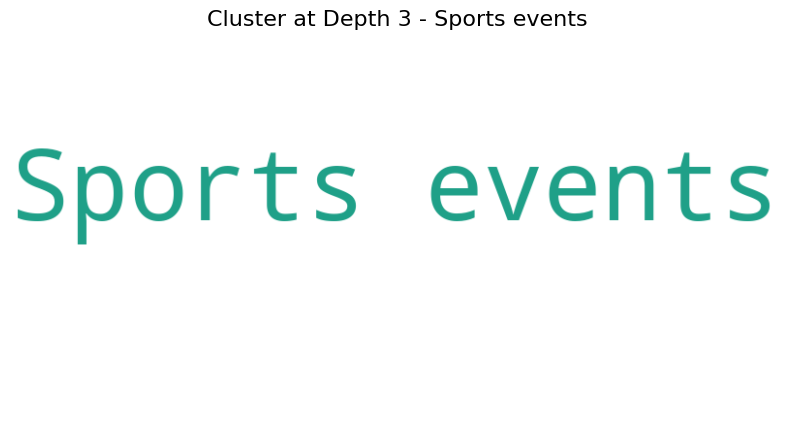

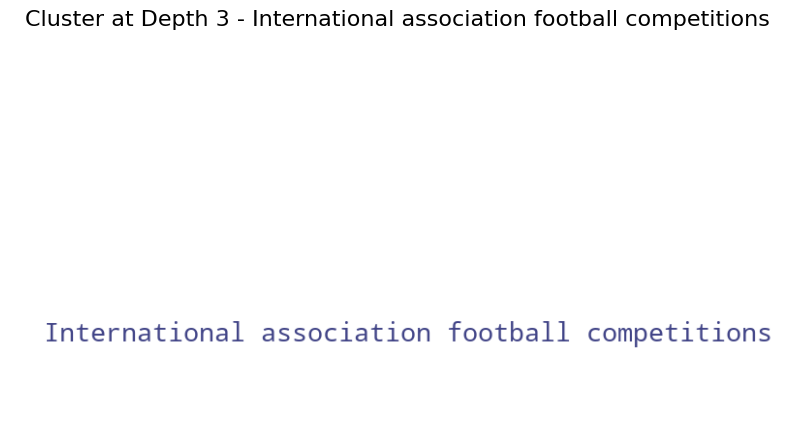

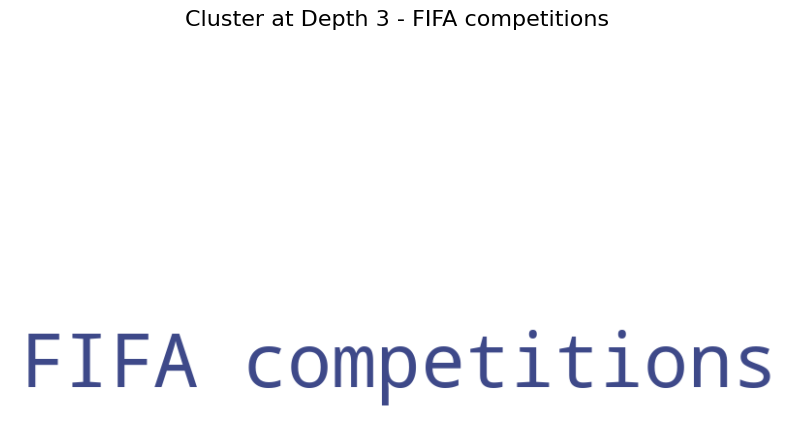

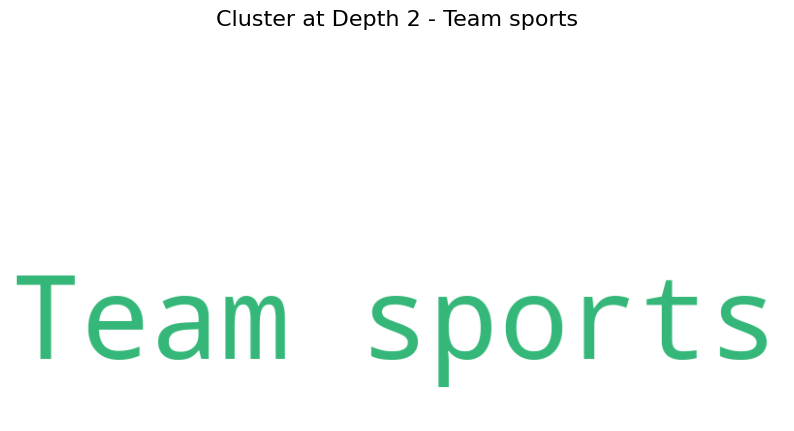

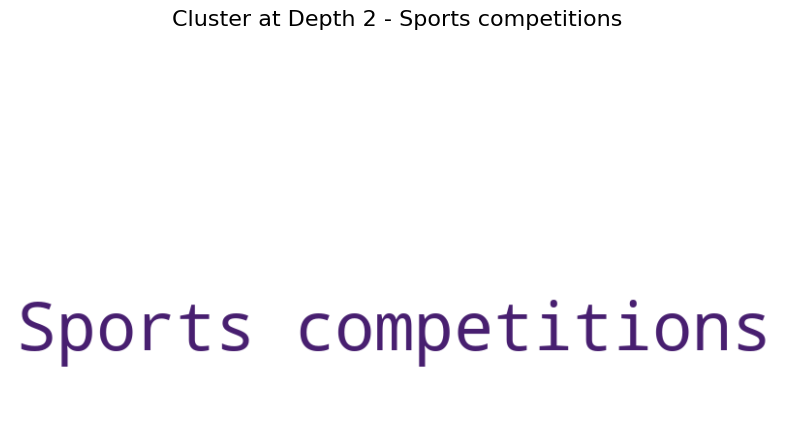

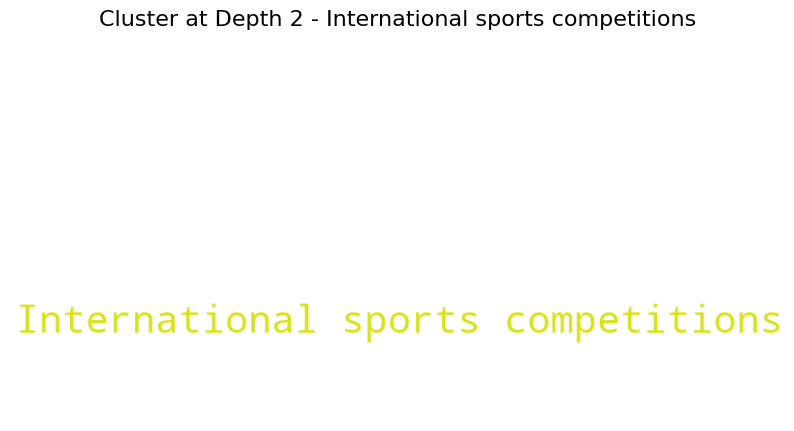

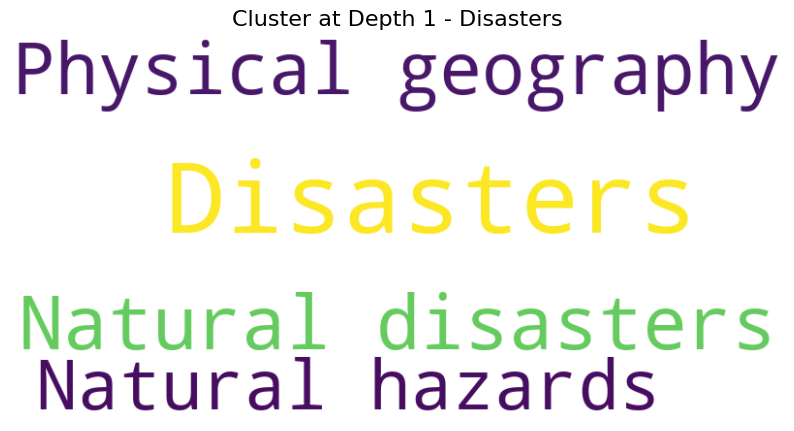

In [6]:
# Visualization - Word Cloud
def generate_word_cloud(topic_data, title=None):
    """
    Generate a word cloud visualization from a list of topics and their frequencies.

    Args:
        topic_data (list[dict]): A list of dictionaries, where each dictionary represents a topic and its frequency.
                                 Example: [{"topic": "Politics", "frequency": 20}, {"topic": "Economy", "frequency": 15}]
        title (str, optional): The title of the word cloud visualization. Default is None.

    What it Does:
        - Converts the input `topic_data` into a dictionary of frequencies.
        - Uses the WordCloud library to generate a word cloud from these frequencies.
        - Displays the word cloud using Matplotlib.
        - If a title is provided, it adds the title above the word cloud.

    Returns:
        None: Displays the word cloud plot.
    """
    frequencies = {topic["topic"]: topic["frequency"] for topic in topic_data}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=16)
    plt.show()

def display_cluster_wordcloud(cluster_node, all_topics, topic_frequency, depth=0):
    """
    Recursively generate word clouds for clusters in a hierarchical structure.

    Args:
        cluster_node (dict): A dictionary representing a node in the cluster hierarchy.
                             Contains:
                             - "topics": List of topic indices in the current cluster.
                             - "subclusters": List of child cluster dictionaries (each in the same format).
        all_topics (list[str]): A list of all topic names, where the index corresponds to the topic ID.
                                Example: ["Politics", "Economy", "Science"]
        topic_frequency (np.array): An array of frequencies for each topic, where index matches the topic ID.
                                    Example: [20, 15, 10]
        depth (int, optional): The depth of the current cluster in the hierarchy. Default is 0.

    What it Does:
        - Extracts the topics and their frequencies for the current cluster using the indices in `cluster_node["topics"]`.
        - Generates a word cloud for the current cluster with a title that indicates its depth.
        - Recursively calls itself for each subcluster in `cluster_node["subclusters"]` to generate word clouds for deeper levels.

    Returns:
        None: Displays the word cloud plots for the current cluster and all its subclusters.
    """
    # Get the topics for the current cluster
    topic_data = [
        {"topic": all_topics[idx], "frequency": int(topic_frequency[idx])}
        for idx in cluster_node["topics"]
    ]
    
    # Generate title based on the depth and primary topic (if available)
    if topic_data:
        title = f"Cluster at Depth {depth} - {topic_data[0]['topic']}"
    else:
        title = f"Cluster at Depth {depth}"

    # Generate word cloud for the current cluster
    generate_word_cloud(topic_data, title=title)

    # Recursively generate word clouds for subclusters
    for sub_node in cluster_node["subclusters"]:
        display_cluster_wordcloud(sub_node, all_topics, topic_frequency, depth=depth + 1)

# Initial Word Cloud for All Topics
print("Displaying Word Cloud for All Topics")
generate_word_cloud(
    [{"topic": all_topics[i], "frequency": topic_frequency[i]} for i in range(num_topics)], 
    title="All Topics Word Cloud"
)

# Recursive Word Clouds for Clusters
print("Displaying Word Clouds for Clusters")
display_cluster_wordcloud(root_cluster, all_topics, topic_frequency)